This notebook demonstrates Kausal framework on Lorenz'96 dynamics. 

> __NOTE__: If you have not already done so, run through the notebook on `coupled_rossler` to get a sense of the overall workflow.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('..')

import numpy as np
import torch
import torchdiffeq

import matplotlib.pyplot as plt
from matplotlib import cm
from tqdm import tqdm

from kausal.generator import lorenz96
from kausal.koopman import Kausal
from kausal import stats
from kausal.observables import MLPFeatures


# 1. Causal Koopman

### Causal dependence with cumulative neighborhood shifts

We evaluate the spatial dependence. We attempt to reproduce Figures 7, 8 in the paper (https://arxiv.org/pdf/2410.10103) for Lorenz'96 dynamics.

In [3]:
# Integration
t0, t1 = 0.0, 10.0
dt = 0.001
steps = int((t1 - t0) / dt)
n_train = int(0.8 * steps)

N = 101  # Number of sites / 'oscillators'
F = 4.0 
initial_state = F + torch.randn(N)

# Solve the system
solver = torchdiffeq.odeint

def solve_dynamics(t0, t1, dt, initial_state, params):
    """Solve dynamics"""
    t = torch.linspace(t0, t1, int((t1 - t0) / dt))
    dynamics = lambda t, state: lorenz96(t, state, params)

    solution = solver(
        dynamics,
        initial_state,
        t,
        method = 'dopri5',
        options = {'max_num_steps': 100000}
    )
    return t, solution

params = (F, )
t, solution = solve_dynamics(t0, t1, dt, initial_state, params)

# Extract results
omega = solution.T


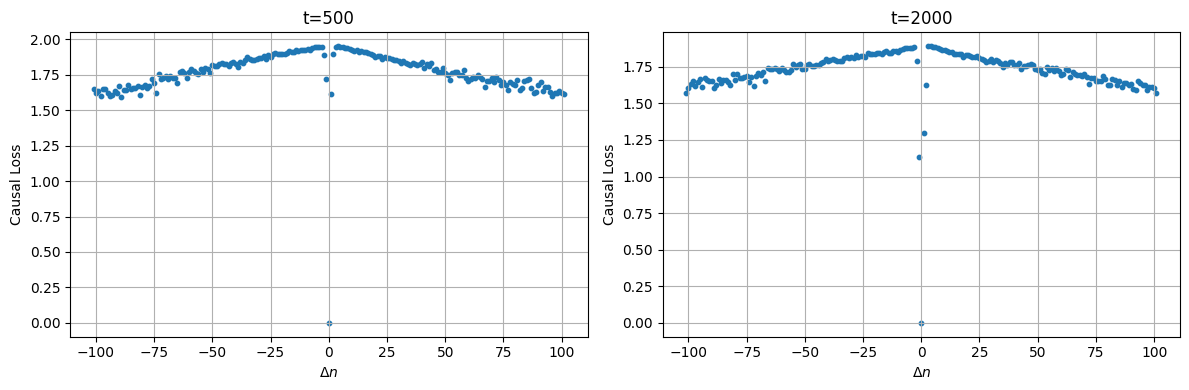

In [4]:
# Causal effect (cumulative neighborhood effect)
center_idx = 51
neighborhood_range = range(-N, N + 1)
time_shifts = [500, 2000]

f, ax = plt.subplots(1, len(time_shifts), figsize=(12, 4))

for i, time_shift in enumerate(time_shifts):
    # Effect (centered at the specified index)
    effect = omega[center_idx : center_idx + 1, :]

    # Compute causal losses for varying neighborhood ranges
    causal_losses = []
    for delta_n in neighborhood_range:
        # Neighborhood indices (cumulative neighborhood effect)
        neighbor_indices = [(center_idx + j) % N for j in range(delta_n, 0)] if delta_n < 0 else \
                           [(center_idx + j) % N for j in range(1, delta_n + 1)]
        cause = omega[neighbor_indices, :]

        # Initialize Kausal object and compute causal loss
        causal_koopman = Kausal(cause=cause, effect=effect)
        causal_losses.append(causal_koopman.evaluate(time_shift=time_shift))

    # Plot causal losses
    ax[i].scatter(neighborhood_range, causal_losses, s=10)
    ax[i].set_title(f't={time_shift}')
    ax[i].grid()
    ax[i].set_xlabel(r"$\Delta n$")
    ax[i].set_ylabel("Causal Loss")

plt.tight_layout()
plt.show();


### 1a. Causal dependence with increasing shifts

In [5]:
# Initialize Kausal object, where we can pass in the cause-effect variables to be analyzed

cause = omega[center_idx-3:center_idx, :]  # (center-3, ..., center) oscillators
effect = omega[center_idx:center_idx+3, :] # (center, ..., center+3) oscillators

## Test C --> E
causal_koopman = Kausal(
    cause = cause,
    effect = effect
)


In [6]:
# Causal effect is estimated through the (marginal - joint) loss
time_shifts = torch.arange(1, 2000, 50)
causal_effect = causal_koopman.evaluate_multistep(time_shifts = time_shifts)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:30<00:00,  1.32it/s]


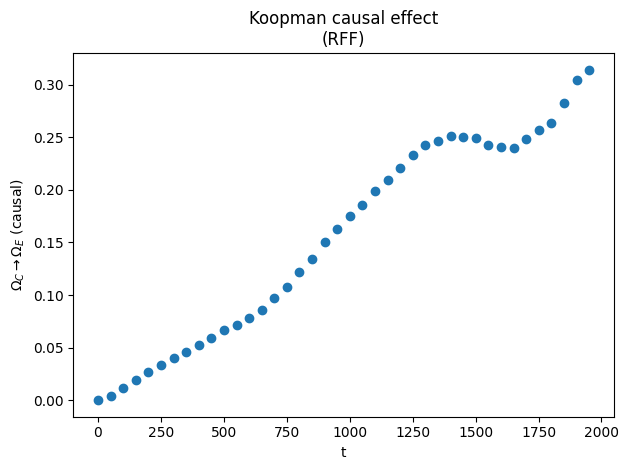

In [7]:
# Plot causal shift
# NOTE: increasing causal error in the causal direction as time dependency increases.
plt.scatter(time_shifts, causal_effect)
plt.xlabel('t')
plt.ylabel(r'$\Omega_C \rightarrow \Omega_E$ (causal)')
plt.title('Koopman causal effect\n(RFF)')
plt.tight_layout()
plt.show();


# 2. Deep Causal Koopman
Now, we use neural network (encoder-decoder __MLP__) to approximate the lifting operators, i.e., y(t) = f[x(t)], where x(t) is the high-dimensional non-linear states, and y(t) is the observables. We perform similar causal analysis as above!

In [8]:
# Initialize Kausal object, where we now specify DL-based observable functions.

# Specify hyperparameters
hidden_channels = [16, 32]

## Test C --> E
cause = omega[center_idx-3:center_idx, :]  # (center-3, ..., center) oscillators
effect = omega[center_idx:center_idx+3, :] # (center, ..., center+3) oscillators

causal_koopman = Kausal(
    marginal_observable = MLPFeatures(in_channels=3, hidden_channels=hidden_channels, out_channels=3),
    joint_observable = MLPFeatures(in_channels=6, hidden_channels=hidden_channels, out_channels=3),
    cause = cause,
    effect = effect
)


In [9]:
# We first have to fit/train the observable functions
lr = 1e-2
epochs = 500

# 1. Causal direction
marginal_loss_ce, joint_loss_ce = causal_koopman.fit(
    n_train = n_train, 
    epochs = epochs, 
    lr = lr, 
    batch_size = n_train
)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:35<00:00, 14.10it/s]


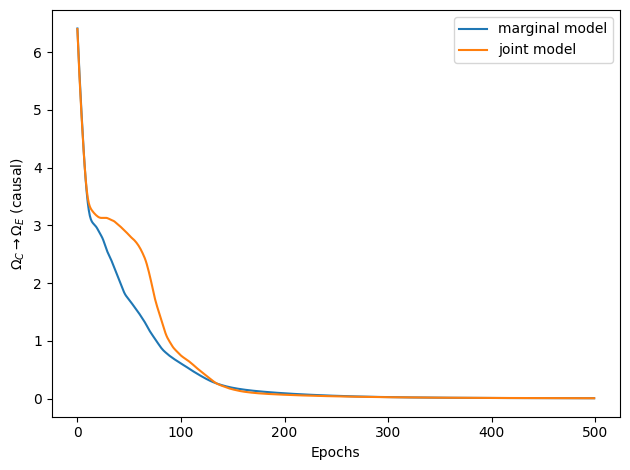

In [10]:
# Plot training losses
plt.plot(marginal_loss_ce, label='marginal model')
plt.plot(joint_loss_ce, label='joint model')
plt.xlabel('Epochs')
plt.ylabel(r'$\Omega_C \rightarrow \Omega_E$ (causal)')
plt.legend()
plt.tight_layout()
plt.show();


### 2a. Causal dependence with increasing shifts

In [11]:
# Causal effect is estimated through the (marginal - joint) loss
time_shifts = torch.arange(1, 2000, 50)
causal_effect = causal_koopman.evaluate_multistep(time_shifts = time_shifts)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 60.60it/s]


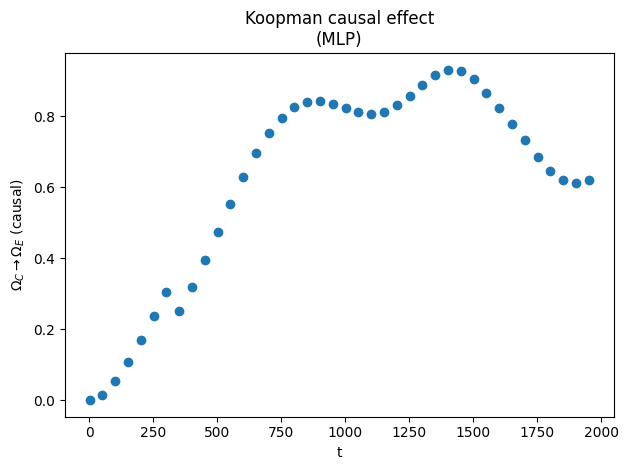

In [12]:
# Plot causal shift
# NOTE: increasing causal error in the causal direction as time dependency increases.
plt.scatter(time_shifts, causal_effect)
plt.xlabel('t')
plt.ylabel(r'$\Omega_C \rightarrow \Omega_E$ (causal)')
plt.title('Koopman causal effect\n(MLP)')
plt.tight_layout()
plt.show();
